# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS

In [1]:
import duckdb, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

### Options

In [2]:
START_YEAR = 2005

SELECT_HYPERPARAMETERS = True

### Load data

In [3]:
con = duckdb.connect("./data/us_births.db", read_only=True)

df = con.execute(
    f"""
    SELECT
        -- (training label) indicated if C or P, otherwise not
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1::UTINYINT
            ELSE 0::UTINYINT
        END AS ca_down_c_or_p,
        -- ==================== date of birth ====================
        year,
        -- month of birth
        dob_mm,
        -- day of week of birth (1-7)
        dob_wk,
        -- time of birth (0000-2359)
        CASE
            WHEN dob_tt >= 0 AND dob_tt <= 2359 THEN dob_tt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dob_tt,
        -- ==================== birth location ====================
        -- birth place (1: hospital, 2: not hospital, 3: unknown/not stated)
        bfacil3,
        -- ==================== characteristics of baby ====================
        -- sex of baby
        CASE
            WHEN sex = 'M' THEN 1::UTINYINT
            WHEN sex = 'F' THEN 0::UTINYINT
            ELSE NULL
        END AS sex,
        -- birth weight (grams)
        CASE
            WHEN dbwt >= 227 AND dbwt <= 8165 THEN dbwt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dbwt,
        -- ==================== characteristics of pregnancy ====================
        -- plurality (1: single... 4 quadpruplet or higher)
        dplural,
        -- month prenatal care began (1 to 10, 0: no prenatal care)
        CASE
            WHEN precare >= 0 AND precare <= 10 THEN precare
            WHEN precare = 99 THEN precare
            ELSE NULL
        END AS precare,
        -- combined gestation estimate
        CASE
            WHEN gestrec10 >= 1 AND gestrec10 <= 10 THEN gestrec10
            WHEN gestrec10 = 99 THEN gestrec10
            ELSE NULL
        END AS gestrec10,
        -- pre-pregnancy weight recode (in pounds)
        CASE
            WHEN pwgt_r >= 75 AND pwgt_r <= 375 THEN pwgt_r
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS pwgt_r,
        -- weight gain in pounds (98 = 98+)
        CASE
            WHEN wtgain >= 0 AND wtgain <= 98 THEN wtgain
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS wtgain,
        -- maternal body mass index
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END
        AS bmi,
        -- ==================== pregnancy risk factors ====================
        -- pre-pregnancy diabetes
        CASE
            WHEN rf_pdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_pdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_pdiab,
        -- gestational diabetes
        CASE
            WHEN rf_gdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_gdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_gdiab,
        -- pre-pregnancy hypertension
        CASE
            WHEN rf_phype = 'Y' THEN 1::UTINYINT
            WHEN rf_phype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_phype,
        -- gestational hypertension
        CASE
            WHEN rf_ghype = 'Y' THEN 1::UTINYINT
            WHEN rf_ghype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ghype,
        -- hypertension eclampsia
        CASE
            WHEN rf_ehype = 'Y' THEN 1::UTINYINT
            WHEN rf_ehype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ehype,
        -- previous preterm birth
        CASE
            WHEN rf_ppterm = 'Y' THEN 1::UTINYINT
            WHEN rf_ppterm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ppterm,
        -- infertility treatment used
        CASE
            WHEN rf_inftr = 'Y' THEN 1::UTINYINT
            WHEN rf_inftr = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_inftr,
        -- fertility enhancing drugs
        CASE
            WHEN rf_fedrg = 'Y' THEN 1::UTINYINT
            WHEN rf_fedrg = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_fedrg,
        -- asst. reproductive technology
        CASE
            WHEN rf_artec = 'Y' THEN 1::UTINYINT
            WHEN rf_artec = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_artec,
        -- no risk factors reported
        CASE
            WHEN no_risks <= 1 THEN no_risks
            ELSE NULL
        END AS no_risks,
        -- ==================== labor and delivery ====================
        -- induction of labor
        CASE
            WHEN ld_indl = 'Y' THEN 1::UTINYINT
            WHEN ld_indl = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_indl,
        -- augmentation of labor
        CASE
            WHEN ld_augm = 'Y' THEN 1::UTINYINT
            WHEN ld_augm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_augm,
        -- fetal presentation at delivery
        CASE
            WHEN me_pres >= 1 AND me_pres <= 3 THEN me_pres
            WHEN me_pres = 9 THEN me_pres
            ELSE NULL
        END AS me_pres,
        -- delivery method recode
        CASE
            WHEN dmeth_rec >= 1 AND dmeth_rec <= 2 THEN dmeth_rec
            WHEN dmeth_rec = 9 THEN dmeth_rec
            ELSE NULL
        END AS dmeth_rec,
        -- ==================== newborn health ====================
        -- five minute apgar score
        CASE
            WHEN apgar5 >= 10 AND apgar5 <= 10 THEN apgar5
            WHEN apgar5 = 99 THEN apgar5
            ELSE NULL
        END AS apgar5,
        -- ten minute apgar score
        CASE
            WHEN apgar10 >= 10 AND apgar10 <= 10 THEN apgar10
            WHEN apgar10 = 99 THEN apgar10
            ELSE NULL
        END AS apgar10,
        -- assisted ventilation (immediately)
        CASE
            WHEN ab_aven1 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven1 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven1,
        -- assisted ventilation > 6 hrs
        CASE
            WHEN ab_aven6 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven6 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven6,
        -- admitted to nicu
        CASE
            WHEN ab_nicu = 'Y' THEN 1::UTINYINT
            WHEN ab_nicu = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_nicu,
        -- surfactant
        CASE
            WHEN ab_surf = 'Y' THEN 1::UTINYINT
            WHEN ab_surf = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_surf,
        -- antibiotics for newborn
        CASE
            WHEN ab_anti = 'Y' THEN 1::UTINYINT
            WHEN ab_anti = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_anti,
        -- seizures
        CASE
            WHEN ab_seiz = 'Y' THEN 1::UTINYINT
            WHEN ab_seiz = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_seiz,
        -- no_abnorm
        CASE
            WHEN no_abnorm >= 0 AND no_abnorm <= 1 THEN no_abnorm
            WHEN no_abnorm = 9 THEN no_abnorm
            ELSE NULL
        END AS no_abnorm,
        -- ==================== identified disorders ====================
        -- congenital disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            ELSE NULL
        END
        AS ca_disor,
        -- anencephaly
        CASE
            WHEN ca_anen = 'Y' THEN 1::UTINYINT
            WHEN ca_anen = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_anen,
        -- meningomyelocele / spina bifida
        CASE
            WHEN ca_mnsb = 'Y' THEN 1::UTINYINT
            WHEN ca_mnsb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_mnsb,
        -- congenital heart defect
        CASE
            WHEN ca_cchd = 'Y' THEN 1::UTINYINT
            WHEN ca_cchd = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cchd,
        -- ca_cdh
        CASE
            WHEN ca_cdh = 'Y' THEN 1::UTINYINT
            WHEN ca_cdh = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cdh,
        -- omphalocele
        CASE
            WHEN ca_omph = 'Y' THEN 1::UTINYINT
            WHEN ca_omph = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_omph,
        -- gastroschisis
        CASE
            WHEN ca_gast = 'Y' THEN 1::UTINYINT
            WHEN ca_gast = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_gast,
        -- limb reduction defect
        CASE
            WHEN ca_limb = 'Y' THEN 1::UTINYINT
            WHEN ca_limb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_limb,
        -- cleft lip w/ or w/o cleft palate
        CASE
            WHEN ca_cleft = 'Y' THEN 1::UTINYINT
            WHEN ca_cleft = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cleft,
        -- cleft palate alone
        CASE
            WHEN ca_clpal = 'Y' THEN 1::UTINYINT
            WHEN ca_clpal = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_clpal,
        -- Hypospadias
        CASE
            WHEN ca_hypo = 'Y' THEN 1::UTINYINT
            WHEN ca_hypo = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_hypo,
        -- suspected chromosomal disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            WHEN ca_disor = 'U' THEN 9::UTINYINT
            ELSE NULL
        END AS ca_disor,
        -- no_congen
        CASE
            WHEN no_congen >= 0 AND no_congen <= 1 THEN no_congen
            WHEN no_congen = 9 THEN no_congen
            ELSE NULL
        END AS no_congen,
        -- ==================== maternal characteristics ====================
        -- maternal age in years
        mage_c,
        -- maternal education
        CASE
            WHEN meduc >= 0 AND meduc < 10 THEN meduc
            ELSE NULL
        END AS meduc,
        -- maternal race
        CASE
            WHEN  mracehisp >= 1 AND mracehisp <= 8 THEN mracehisp
            ELSE NULL
        END AS mracehisp,
        -- ==================== paternal characteristics ====================
        -- father's combined age in years
        CASE
            WHEN fagecomb >= 9 AND fagecomb < 99 THEN fagecomb
            ELSE NULL
        END AS fagecomb,
        -- paternal education
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        -- paternal race
        CASE
            WHEN  fracehisp >= 1 AND fracehisp <= 10 THEN fracehisp
            ELSE NULL
        END AS fracehisp,
        -- ==================== socio-economic indicators ====================
        -- payment source recode
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec,
        -- supplemental nutrition program for women, infants, and children
        CASE
            WHEN wic = 'Y' THEN 1::UTINYINT
            WHEN wic = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS wic
    FROM
        us_births
    WHERE year >= {START_YEAR}
    ORDER BY
        year, dob_mm
    """
).df()

con.close()

df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,ca_down_c_or_p,year,dob_mm,dob_wk,dob_tt,bfacil3,sex,dbwt,dplural,precare,...,ca_disor_1,no_congen,mage_c,meduc,mracehisp,fagecomb,feduc,fracehisp,pay_rec,wic
0,0,2005,1,3,<NA>,2,0,3402,1,<NA>,...,<NA>,<NA>,32,<NA>,6,<NA>,<NA>,9,<NA>,<NA>
1,0,2005,1,3,<NA>,2,0,<NA>,1,<NA>,...,<NA>,<NA>,29,<NA>,<NA>,<NA>,<NA>,9,<NA>,<NA>
2,0,2005,1,6,<NA>,2,0,3657,1,<NA>,...,<NA>,<NA>,37,<NA>,6,<NA>,<NA>,6,<NA>,<NA>
3,0,2005,1,6,<NA>,2,1,3430,1,<NA>,...,<NA>,<NA>,38,<NA>,6,<NA>,<NA>,6,<NA>,<NA>
4,0,2005,1,7,<NA>,1,0,2630,1,<NA>,...,<NA>,<NA>,22,<NA>,1,<NA>,<NA>,9,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78581855,0,2024,12,3,<NA>,1,0,3600,1,3,...,0,1,31,3,1,41,5,6,1,1
78581856,0,2024,12,4,<NA>,1,0,3090,1,2,...,0,1,31,3,7,37,3,7,1,1
78581857,0,2024,12,1,45,1,1,2512,1,3,...,0,1,29,3,6,<NA>,<NA>,8,1,1
78581858,0,2024,12,1,<NA>,1,0,2865,1,3,...,0,1,35,2,7,36,2,7,4,1


#### Missing values

### Initial features

In [4]:
numeric = [
    "year",
    "dbwt",
    "pwgt_r",
    "wtgain",
    "bmi",
    "mage_c",
    "fagecomb",
]

categorical = [
    "dob_mm",
    "dob_wk",
    "bfacil3",
    "sex",
    "precare",
    "gestrec10",
    "rf_pdiab",
    "rf_gdiab",
    "rf_phype",
    "rf_ghype",
    "rf_ehype",
    "rf_ppterm",
    "rf_inftr",
    "rf_fedrg",
    "rf_artec",
    "no_risks",
    "ld_indl",
    "ld_augm",
    "me_pres",
    "dmeth_rec",
    "apgar5",
    "apgar10",
    "ab_aven1",
    "ab_aven6",
    "ab_nicu",
    "ab_surf",
    "ab_anti",
    "ab_seiz",
    "no_abnorm",
    "ca_anen",
    "ca_mnsb",
    "ca_cchd",
    "ca_cdh",
    "ca_omph",
    "ca_gast",
    "ca_limb",
    "ca_cleft",
    "ca_clpal",
    "ca_hypo",
    "ca_disor",
    "no_congen",
    "meduc",
    "mracehisp",
    "feduc",
    "fracehisp",
    "pay_rec",
    "wic",
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_or_p"]


In [5]:

print(f"Data set contains {X.shape[0]} observations with {X.shape[1]} features.")

78581860 54


### Prepare training and validation data

In [6]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=RANDOM_SEED
)

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False
)

In [7]:
neg_count = (y_train == 0).count()
pos_count = (y_train == 1).count()
scale_pos_weight = neg_count / pos_count

In [ ]:
train_set = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid_set = lgb.Dataset(X_valid, label=y_valid, reference=train_set, free_raw_data=False)

### Hyperparameter tuning

In [9]:
dtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain, free_raw_data=False)

def objective(trial):
    params = {
        "objective": "binary",
        "metric": ["average_precision", "binary_logloss"],
        "boosting_type": "gbdt",

        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        "max_bin": trial.suggest_int("max_bin", 63, 255),

        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 20000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),

        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),

        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),

        "scale_pos_weight": scale_pos_weight,

        "seed": RANDOM_SEED,
        "force_col_wise": True,
        "num_threads": 22,
        "verbosity": 1,
        # If you use categorical features, pass categorical_feature to Dataset or train().
    }

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        dtrain,
        num_boost_round=5000,
        valid_sets=[dvalid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=5),
            lgb.log_evaluation(period=1),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=5)

print(study.best_params, study.best_value)

[I 2025-12-18 14:07:43,537] A new study created in memory with name: no-name-e53a0236-a8ec-476b-9756-5dc1bb8a8709


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-12-18 14:26:53,877] Trial 0 finished with value: 0.6449549400662161 and parameters: {'learning_rate': 0.034426663874544426, 'max_bin': 132, 'num_leaves': 326, 'min_data_in_leaf': 5343, 'min_gain_to_split': 0.46740970788810987, 'feature_fraction': 0.915719374176247, 'bagging_fraction': 0.8934938791248219, 'bagging_freq': 7, 'lambda_l1': 0.25778409489395027, 'lambda_l2': 11.966018975703484}. Best is trial 0 with value: 0.6449549400662161.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-12-18 14:31:12,444] Trial 1 finished with value: 0.6473734884360687 and parameters: {'learning_rate': 0.12390884486709394, 'max_bin': 207, 'num_leaves': 341, 'min_data_in_leaf': 944, 'min_gain_to_split': 0.17680803405451195, 'feature_fraction': 0.6818361398649563, 'bagging_fraction': 0.8390122046955855, 'bagging_freq': 5, 'lambda_l1': 9.06348018788486, 'lambda_l2': 43.44838595213325}. Best is trial 1 with value: 0.6473734884360687.


Early stopping, best iteration is:
[85]	valid_0's average_precision: 0.647373	valid_0's binary_logloss: 0.00124002
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-12-18 14:46:00,592] Trial 2 finished with value: 0.6507582625104742 and parameters: {'learning_rate': 0.04250974227530962, 'max_bin': 71, 'num_leaves': 310, 'min_data_in_leaf': 216, 'min_gain_to_split': 0.09750378338551635, 'feature_fraction': 0.6109914425849833, 'bagging_fraction': 0.8885138251687943, 'bagging_freq': 3, 'lambda_l1': 2.009049365989414, 'lambda_l2': 27.214827318296276}. Best is trial 2 with value: 0.6507582625104742.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-12-18 14:57:26,588] Trial 3 finished with value: 0.632430859905116 and parameters: {'learning_rate': 0.08001825343759915, 'max_bin': 222, 'num_leaves': 125, 'min_data_in_leaf': 259, 'min_gain_to_split': 0.5618136200579118, 'feature_fraction': 0.7691056937491763, 'bagging_fraction': 0.7817146173549465, 'bagging_freq': 2, 'lambda_l1': 2.4508080590105363, 'lambda_l2': 28.633702519183057}. Best is trial 2 with value: 0.6507582625104742.


Early stopping, best iteration is:
[233]	valid_0's average_precision: 0.632431	valid_0's binary_logloss: 0.0013068
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 14:58:39,321] Trial 4 finished with value: 0.6105501786068168 and parameters: {'learning_rate': 0.11199307800868272, 'max_bin': 231, 'num_leaves': 55, 'min_data_in_leaf': 291, 'min_gain_to_split': 0.7491578634209206, 'feature_fraction': 0.9721776432315514, 'bagging_fraction': 0.9998520340237325, 'bagging_freq': 2, 'lambda_l1': 5.538843511000393, 'lambda_l2': 47.18714061339411}. Best is trial 2 with value: 0.6507582625104742.


Early stopping, best iteration is:
[13]	valid_0's average_precision: 0.61055	valid_0's binary_logloss: 0.0016515
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1159
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 14:59:08,789] Trial 5 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 14:59:35,380] Trial 6 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-12-18 15:00:14,883] Trial 7 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 15:12:43,207] Trial 8 finished with value: 0.6487454223608186 and parameters: {'learning_rate': 0.05068278104788185, 'max_bin': 210, 'num_leaves': 86, 'min_data_in_leaf': 3009, 'min_gain_to_split': 0.07886292709052278, 'feature_fraction': 0.8015861134922628, 'bagging_fraction': 0.805296953362594, 'bagging_freq': 9, 'lambda_l1': 9.422436947235976, 'lambda_l2': 41.166044441917805}. Best is trial 2 with value: 0.6507582625104742.


Early stopping, best iteration is:
[270]	valid_0's average_precision: 0.648745	valid_0's binary_logloss: 0.00124383
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 15:13:31,500] Trial 9 finished with value: 0.1881240266031167 and parameters: {'learning_rate': 0.07081004163262271, 'max_bin': 106, 'num_leaves': 154, 'min_data_in_leaf': 8597, 'min_gain_to_split': 0.02113782177399559, 'feature_fraction': 0.9455245444086119, 'bagging_fraction': 0.9360549123568471, 'bagging_freq': 3, 'lambda_l1': 4.412573021483705, 'lambda_l2': 22.630757955112152}. Best is trial 2 with value: 0.6507582625104742.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.188124	valid_0's binary_logloss: 0.0109068
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 15:13:59,954] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 985
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 15:14:42,852] Trial 11 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 603
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 15:33:15,999] Trial 12 finished with value: 0.6489083774859771 and parameters: {'learning_rate': 0.02785570572321398, 'max_bin': 66, 'num_leaves': 75, 'min_data_in_leaf': 1180, 'min_gain_to_split': 0.24064004916274356, 'feature_fraction': 0.7048128726661415, 'bagging_fraction': 0.6118076450270588, 'bagging_freq': 9, 'lambda_l1': 2.767559694257336, 'lambda_l2': 38.58276538117046}. Best is trial 2 with value: 0.6507582625104742.


Early stopping, best iteration is:
[443]	valid_0's average_precision: 0.648908	valid_0's binary_logloss: 0.00124224
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 15:33:45,949] Trial 13 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 15:34:13,322] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 15:34:41,338] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 15:35:12,907] Trial 16 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 15:43:20,898] Trial 17 finished with value: 0.6506627066453186 and parameters: {'learning_rate': 0.03827456046168759, 'max_bin': 149, 'num_leaves': 56, 'min_data_in_leaf': 425, 'min_gain_to_split': 0.12143503060999224, 'feature_fraction': 0.732357883729521, 'bagging_fraction': 0.7405693081599691, 'bagging_freq': 10, 'lambda_l1': 1.3819353536077847, 'lambda_l2': 15.946654535079286}. Best is trial 2 with value: 0.6507582625104742.


Early stopping, best iteration is:
[199]	valid_0's average_precision: 0.650663	valid_0's binary_logloss: 0.00122306
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 15:53:48,991] Trial 18 finished with value: 0.6516140022508535 and parameters: {'learning_rate': 0.04045086284084711, 'max_bin': 167, 'num_leaves': 45, 'min_data_in_leaf': 443, 'min_gain_to_split': 0.12349128570385244, 'feature_fraction': 0.7384389468730561, 'bagging_fraction': 0.7355437403180444, 'bagging_freq': 1, 'lambda_l1': 1.1420946916932402, 'lambda_l2': 12.711671807453344}. Best is trial 18 with value: 0.6516140022508535.


Early stopping, best iteration is:
[254]	valid_0's average_precision: 0.651614	valid_0's binary_logloss: 0.00121968
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 15:55:09,002] Trial 19 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2025-12-18 15:55:53,799] Trial 20 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:04:39,453] Trial 21 finished with value: 0.6515323939619396 and parameters: {'learning_rate': 0.04045508187860452, 'max_bin': 145, 'num_leaves': 47, 'min_data_in_leaf': 396, 'min_gain_to_split': 0.12655783476303306, 'feature_fraction': 0.7389023948772006, 'bagging_fraction': 0.749593094173157, 'bagging_freq': 2, 'lambda_l1': 1.1886297214041281, 'lambda_l2': 16.403177974302523}. Best is trial 18 with value: 0.6516140022508535.


Early stopping, best iteration is:
[206]	valid_0's average_precision: 0.651532	valid_0's binary_logloss: 0.00122115
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:14:33,480] Trial 22 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:15:03,378] Trial 23 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:15:48,094] Trial 24 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:16:31,089] Trial 25 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:16:59,172] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 16:17:26,321] Trial 27 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:17:53,451] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:19:21,277] Trial 29 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:26:16,788] Trial 30 finished with value: 0.6516175651605 and parameters: {'learning_rate': 0.04611431498590201, 'max_bin': 107, 'num_leaves': 100, 'min_data_in_leaf': 406, 'min_gain_to_split': 0.0736438842496343, 'feature_fraction': 0.8751850902941978, 'bagging_fraction': 0.9143642405177447, 'bagging_freq': 1, 'lambda_l1': 1.925647117803921, 'lambda_l2': 6.568001958815991}. Best is trial 30 with value: 0.6516175651605.


Early stopping, best iteration is:
[159]	valid_0's average_precision: 0.651618	valid_0's binary_logloss: 0.00122022
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:31:52,062] Trial 31 finished with value: 0.6513532440212509 and parameters: {'learning_rate': 0.045726298028665846, 'max_bin': 85, 'num_leaves': 264, 'min_data_in_leaf': 438, 'min_gain_to_split': 0.06919396198322408, 'feature_fraction': 0.898888387302284, 'bagging_fraction': 0.9202993317684682, 'bagging_freq': 1, 'lambda_l1': 2.352289254937107, 'lambda_l2': 6.4139876027532665}. Best is trial 30 with value: 0.6516175651605.


Early stopping, best iteration is:
[118]	valid_0's average_precision: 0.651353	valid_0's binary_logloss: 0.00122351
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:35:10,918] Trial 32 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:35:51,729] Trial 33 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:39:25,917] Trial 34 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:39:57,303] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:43:48,366] Trial 36 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:44:34,285] Trial 37 finished with value: 0.27466184813509686 and parameters: {'learning_rate': 0.04706208009213855, 'max_bin': 167, 'num_leaves': 57, 'min_data_in_leaf': 2438, 'min_gain_to_split': 0.24725681519177567, 'feature_fraction': 0.7880040171833688, 'bagging_fraction': 0.7736557589276306, 'bagging_freq': 2, 'lambda_l1': 3.3914697899079354, 'lambda_l2': 12.430957700362939}. Best is trial 30 with value: 0.6516175651605.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.274662	valid_0's binary_logloss: 0.00671165
[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 16:45:20,711] Trial 38 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:45:51,118] Trial 39 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:46:18,850] Trial 40 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 16:46:51,304] Trial 41 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 16:47:20,268] Trial 42 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:47:48,270] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:48:35,063] Trial 44 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:49:02,172] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 16:49:30,335] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-18 16:50:02,494] Trial 47 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 16:50:33,583] Trial 48 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 10 rounds


[I 2025-12-18 17:01:54,808] Trial 49 finished with value: 0.6523000864636121 and parameters: {'learning_rate': 0.03288937496333823, 'max_bin': 170, 'num_leaves': 77, 'min_data_in_leaf': 1197, 'min_gain_to_split': 0.03854952333592927, 'feature_fraction': 0.9941146127703994, 'bagging_fraction': 0.7633278333686699, 'bagging_freq': 1, 'lambda_l1': 0.027645583503818516, 'lambda_l2': 13.817083262722434}. Best is trial 49 with value: 0.6523000864636121.


Early stopping, best iteration is:
[292]	valid_0's average_precision: 0.6523	valid_0's binary_logloss: 0.00122546
{'learning_rate': 0.03288937496333823, 'max_bin': 170, 'num_leaves': 77, 'min_data_in_leaf': 1197, 'min_gain_to_split': 0.03854952333592927, 'feature_fraction': 0.9941146127703994, 'bagging_fraction': 0.7633278333686699, 'bagging_freq': 1, 'lambda_l1': 0.027645583503818516, 'lambda_l2': 13.817083262722434} 0.6523000864636121


In [10]:
last_best = {
    "learning_rate": 0.03288937496333823,
    "max_bin": 170,
    "num_leaves": 77,
    "min_data_in_leaf": 1197,
    "min_gain_to_split": 0.03854952333592927,
    "feature_fraction": 0.9941146127703994,
    "bagging_fraction": 0.7633278333686699,
    "bagging_freq": 1,
    "lambda_l1": 0.027645583503818516,
    "lambda_l2": 13.817083262722434
}

base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "verbosity": 1,
    "force_col_wise": True,
    "num_threads": 24,
    "seed": RANDOM_SEED,
}

# Optuna best params (contains only the hyperparameters you searched)
best = study.best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}

In [11]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=5000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=5)
    ]
)


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.773356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
Training until validation scores don't improve for 50 rounds
[5]	train's average_precision: 0.626959	train's binary_logloss: 0.00177026	valid's average_precision: 0.625257	valid's binary_logloss: 0.00177568
[10]	train's average_precision: 0.630728	train's binary_logloss: 0.00164653	valid's average_precision: 0.628885	valid's binary_logloss: 0.00165407
[15]	train's average_precision: 0.633373	train's binary_logloss: 0.00156312	valid's

In [12]:
best_iter = gbm.best_iteration
print("best_iteration:", best_iter)

best_iteration: 293


In [13]:
gbm.save_model(f"./output/features_model_{datetime.now().strftime("%Y%m%d%H%M")}.txt", num_iteration=gbm.best_iteration)

In [14]:
y_valid_pred_proba = gbm.predict(X_valid, num_iteration=gbm.best_iteration)


Validation AUC:  0.9840
Validation AUPRC:0.6508


In [39]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

auc = roc_auc_score(y_valid, y_valid_pred_proba)
ap  = average_precision_score(y_valid, y_valid_pred_proba)   # this is "average_precision"
ll  = log_loss(y_valid, y_valid_pred_proba, labels=[0, 1])   # this is "binary_logloss"

print(f"Validation AUC:             {auc:.4f}")
print(f"Validation average_precision {ap:.6f}")
print(f"Validation binary_logloss:  {ll:.6f}")

Validation AUC:             0.9840
Validation average_precision 0.650773
Validation binary_logloss:  0.001232


In [15]:
lr_age = LogisticRegression(max_iter=1000)
lr_age.fit(X_train[["mage_c"]], y_train)
p_age = lr_age.predict_proba(X_valid[["mage_c"]])[:, 1]
print("AUC (age only):", roc_auc_score(y_valid, p_age))


AUC (age only): 0.7069132781899373


In [16]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame({
    "feature": features,
    "importance_gain": importance_gain
}).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(f"./output/importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

df_imp_gain

,feature,importance_gain
40,no_congen,3.007140e+06
39,ca_disor,1.622377e+06
47,year,5.940216e+05
31,ca_cchd,3.992952e+05
36,ca_cleft,3.944704e+05
38,ca_hypo,3.586209e+05
34,ca_gast,2.933722e+05
37,ca_clpal,2.459477e+05
30,ca_mnsb,2.174867e+05
35,ca_limb,2.005805e+05


In [17]:
pos_idx = y_valid[y_valid == 1].index
neg_idx = y_valid[y_valid == 0].index

n_pos_eval = min(10_000, len(pos_idx))
n_neg_eval = min(10 * n_pos_eval, len(neg_idx))  # 10:1 negatives:positives

rng = np.random.default_rng(123)

pos_sample = rng.choice(pos_idx, size=n_pos_eval, replace=False)
neg_sample = rng.choice(neg_idx, size=n_neg_eval, replace=False)

eval_idx = np.concatenate([pos_sample, neg_sample])
eval_idx = rng.permutation(eval_idx)  # shuffle

X_eval = X_valid.loc[eval_idx]
y_eval = y_valid.loc[eval_idx]


In [18]:


def ap_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)


class LGBMWrapper:
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y=None):
        # Required by sklearn API; we don't actually train here.
        return self

    def predict_proba(self, X):
        # LightGBM Booster.predict gives P(y=1) for binary by default
        p1 = self.booster.predict(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self.booster.predict(X)
        return (p1 >= 0.5).astype(int)


model_wrapped = LGBMWrapper(gbm)


In [19]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=5,
    n_jobs=4,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(f"./output/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
perm_importance

,feature,importance_mean,importance_std
40,no_congen,7.433711e-01,0.002173
34,ca_gast,5.035273e-02,0.001481
24,ab_nicu,4.347973e-02,0.001221
30,ca_mnsb,3.329059e-02,0.001070
52,mage_c,3.014664e-02,0.000500
29,ca_anen,2.944264e-02,0.000868
39,ca_disor,2.652818e-02,0.000457
38,ca_hypo,2.535433e-02,0.000722
32,ca_cdh,2.512826e-02,0.000819
33,ca_omph,2.366113e-02,0.000721


In [25]:
sorted_importances_idx_0 = result.importances_mean.argsort()

importances_0 = pd.DataFrame(
    result.importances[sorted_importances_idx_0].T,
    columns=X_eval.columns[sorted_importances_idx_0],
)

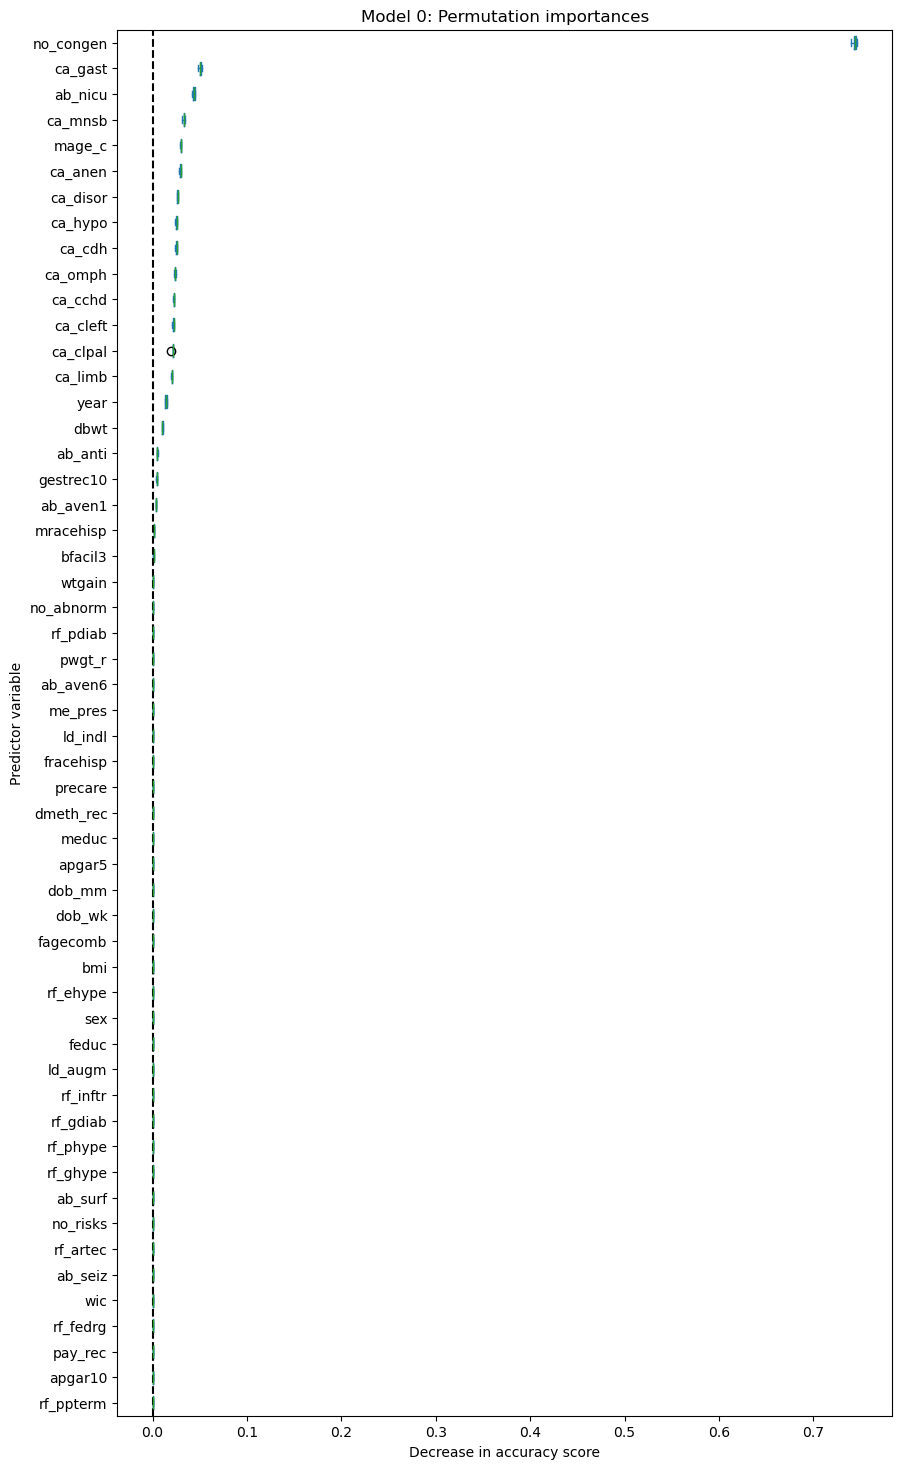

In [28]:
ax = importances_0.plot.box(vert=False, whis=10, figsize=(10, 18))
ax.set_title(f"Model 0: Permutation importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_ylabel("Predictor variable")
plt.show()

In [ ]:
import stats_utils
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy

# need not NA - some columns have many NAs
# distance_0, corr_0 = stats_utils.distance_corr_dissimilarity(X_eval)
# condensed_0 = squareform(distance_0, checks=True)
# dist_linkage_0 = hierarchy.ward(condensed_0)

In [20]:
# e.g. take all positives from X_eval and match them 1:2 with negatives
pos_eval_idx = y_eval[y_eval == 1].index
neg_eval_idx = y_eval[y_eval == 0].index

n_pos_shap = min(5_000, len(pos_eval_idx))
n_neg_shap = min(2 * n_pos_shap, len(neg_eval_idx))  # 2:1 neg:pos

pos_shap = rng.choice(pos_eval_idx, size=n_pos_shap, replace=False)
neg_shap = rng.choice(neg_eval_idx, size=n_neg_shap, replace=False)

shap_idx = np.concatenate([pos_shap, neg_shap])
shap_idx = rng.permutation(shap_idx)

X_shap = X_eval.loc[shap_idx]
y_shap = y_eval.loc[shap_idx]


In [33]:
# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_shap)
# NAs again: clustering_0 = shap.utils.hclust(X_shap, y_shap, linkage="single", random_state=RANDOM_SEED)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values  # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(f"./output/shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

shap_importance

,feature,mean_abs_shap
40,no_congen,4.587084
34,ca_gast,0.533298
31,ca_cchd,0.356065
30,ca_mnsb,0.339330
52,mage_c,0.268059
24,ab_nicu,0.254573
38,ca_hypo,0.243113
36,ca_cleft,0.242216
39,ca_disor,0.219763
29,ca_anen,0.190422


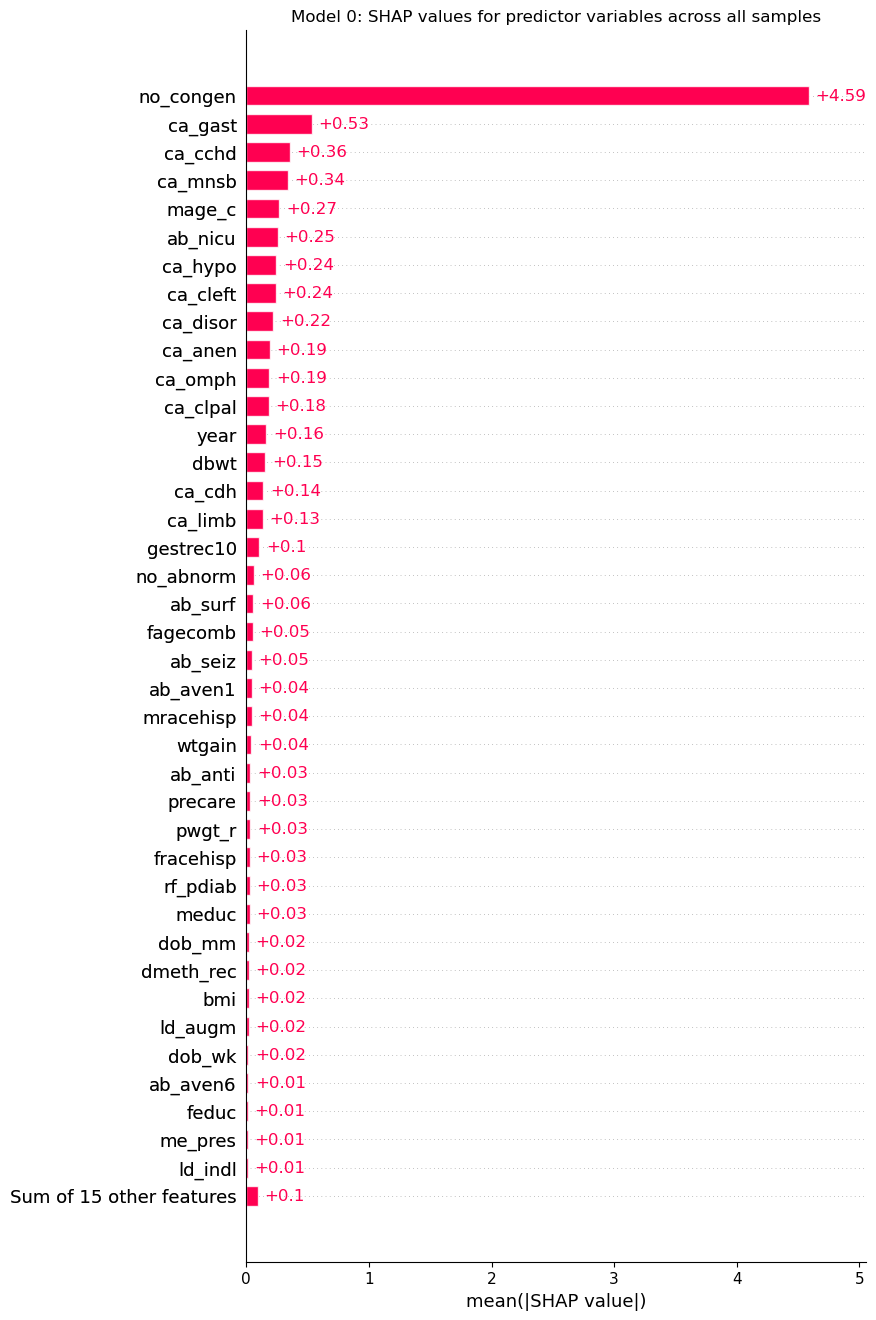

In [36]:
with plt.rc_context({'axes.titlesize': 12}):
    plot = plt.figure(figsize=(8, 16))
    ax = plot.subplots()
    ax.set_title(f"Model 0: SHAP values for predictor variables across all samples")
    shap.plots.bar(explanation, max_display=40, ax=ax)

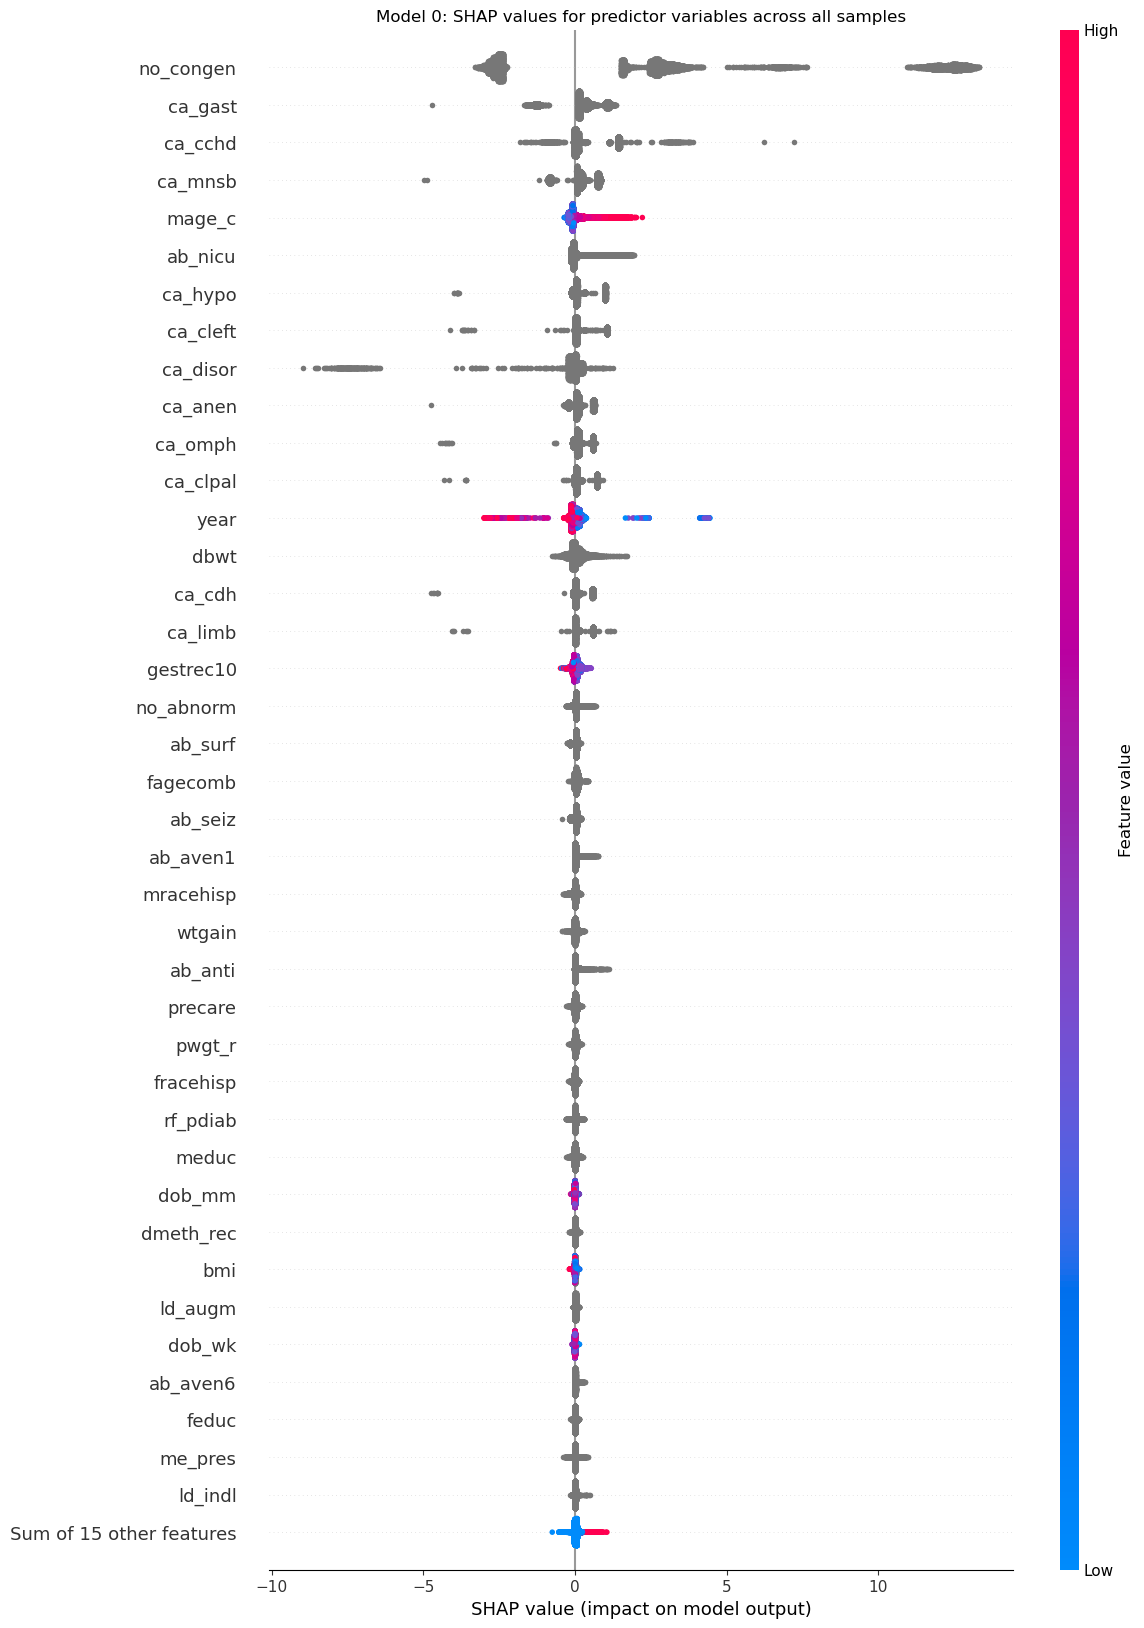

In [38]:
with plt.rc_context({'axes.titlesize': 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model 0: SHAP values for predictor variables across all samples")
    shap.plots.beeswarm(explanation, max_display=40, plot_size=(12, 20))


Feature: dob_mm


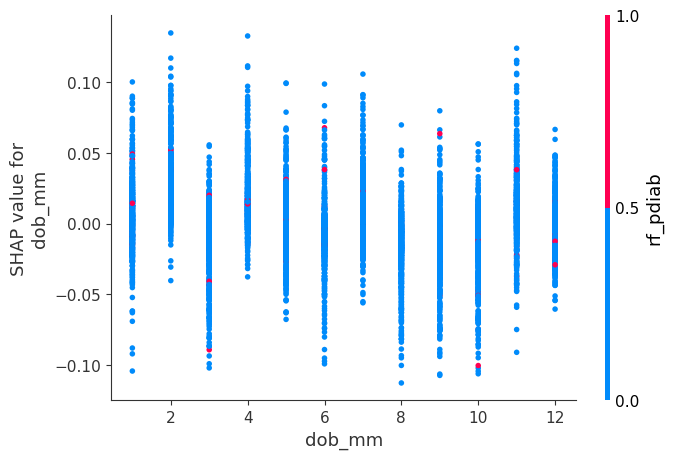


Feature: dob_wk


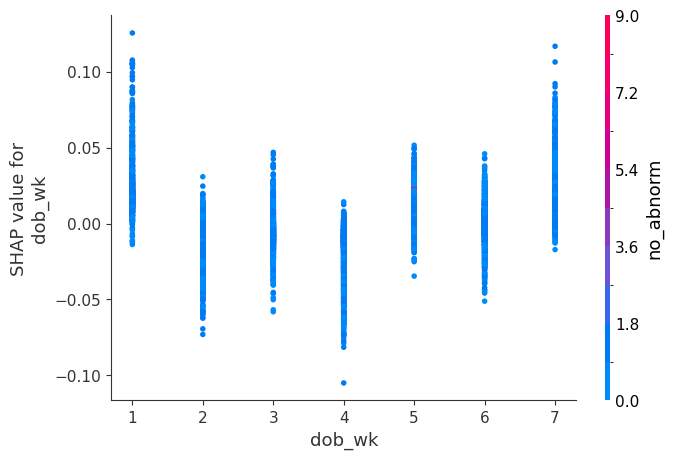


Feature: bfacil3


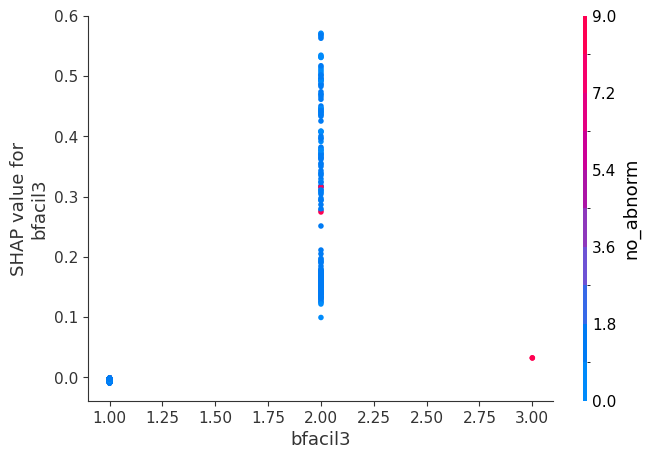


Feature: sex


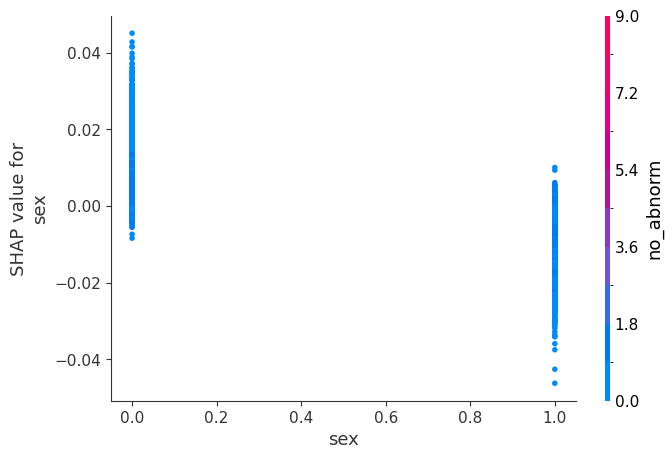


Feature: precare


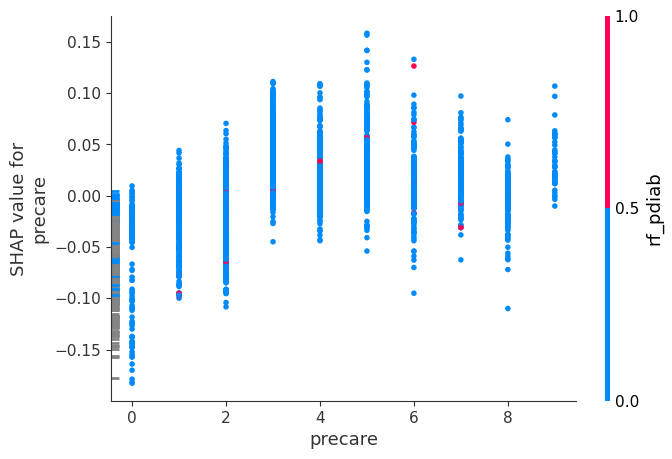


Feature: gestrec10


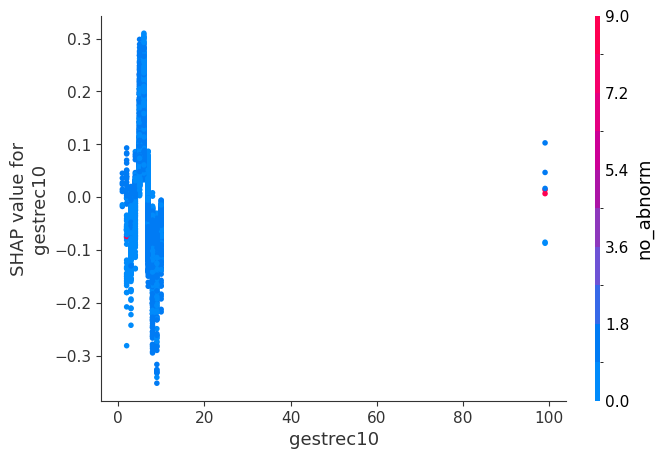


Feature: rf_pdiab


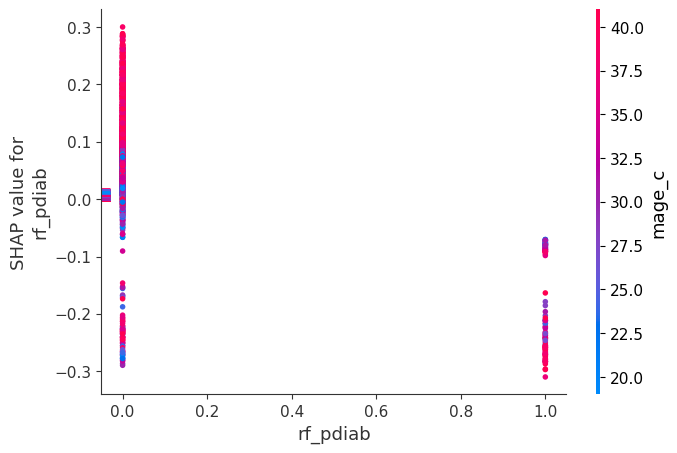


Feature: rf_gdiab


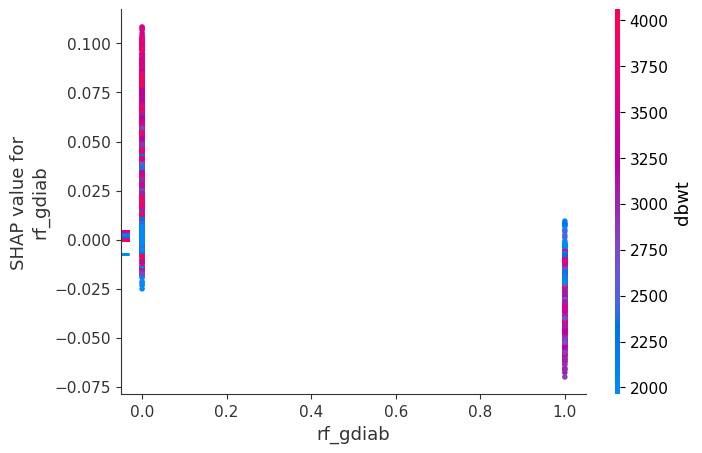


Feature: rf_phype


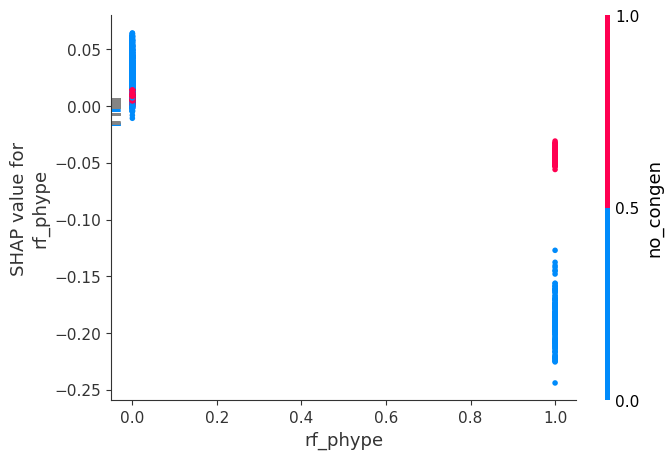


Feature: rf_ghype


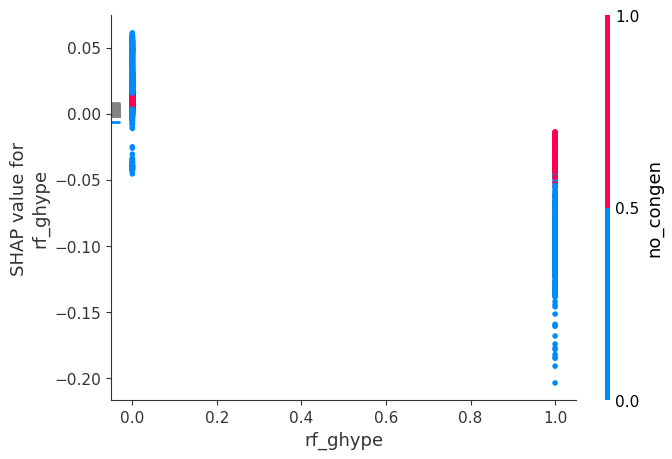


Feature: rf_ehype


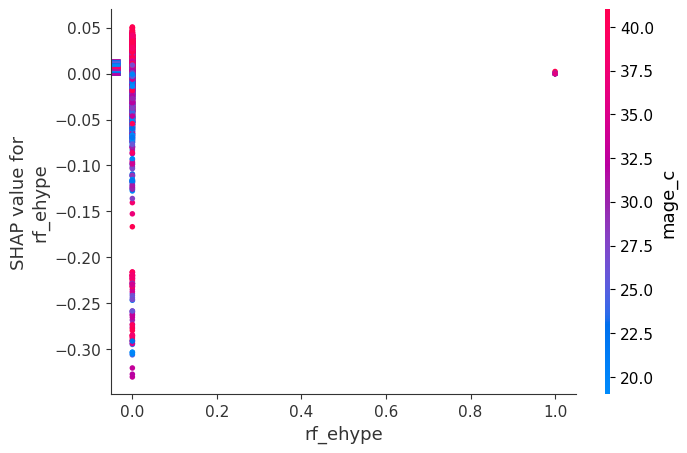


Feature: rf_ppterm


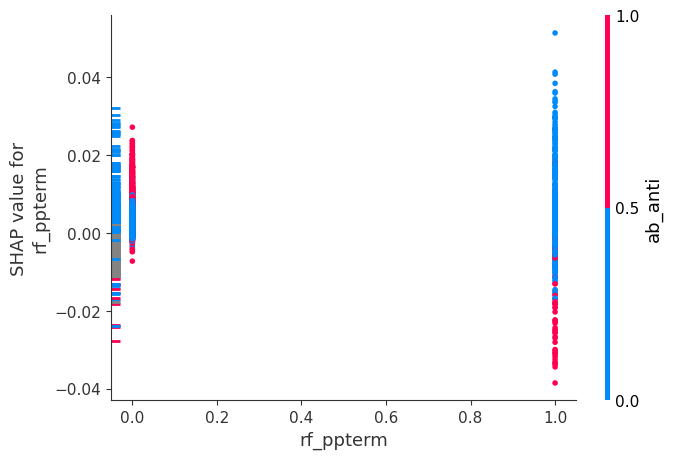


Feature: rf_inftr


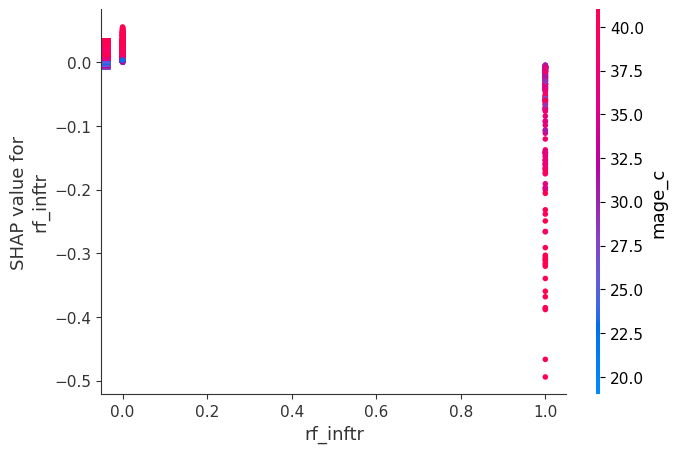


Feature: rf_fedrg


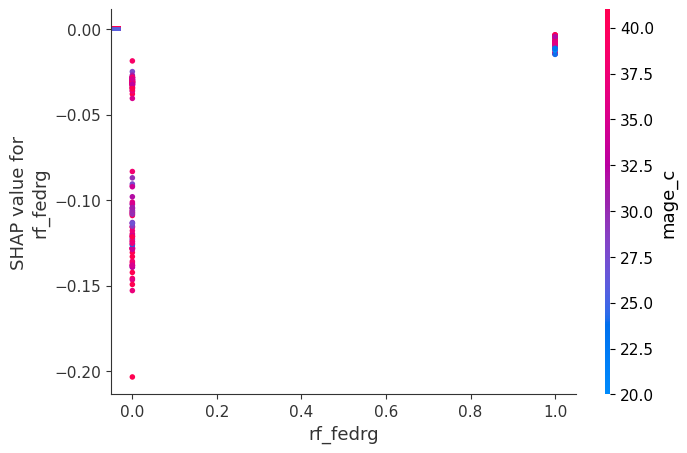


Feature: rf_artec


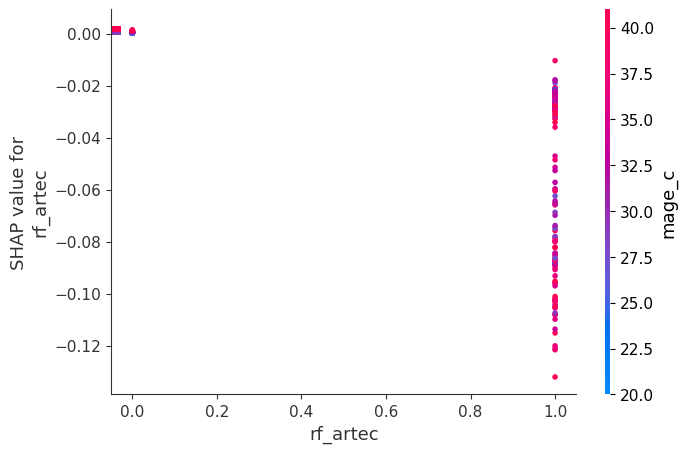


Feature: no_risks


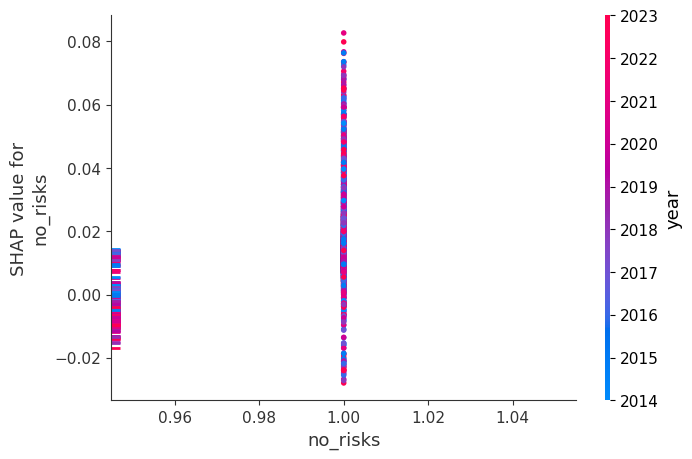


Feature: ld_indl


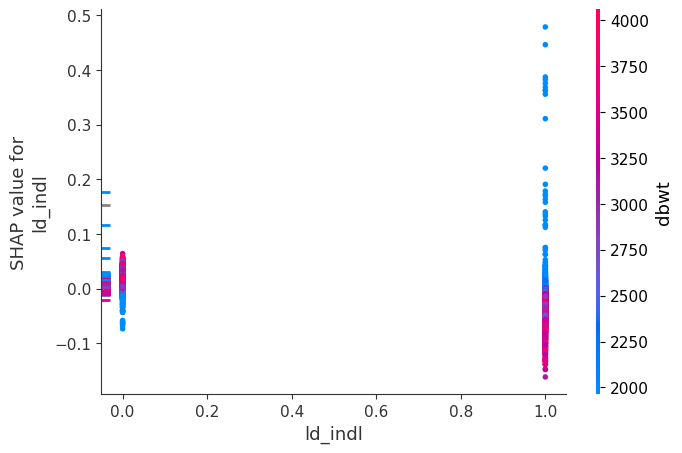


Feature: ld_augm


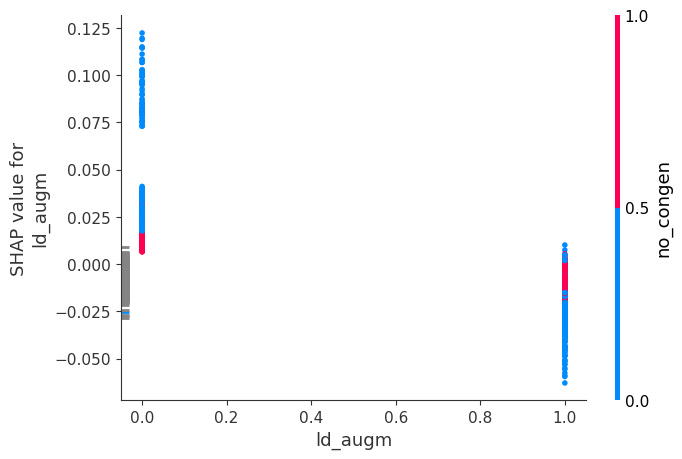


Feature: me_pres


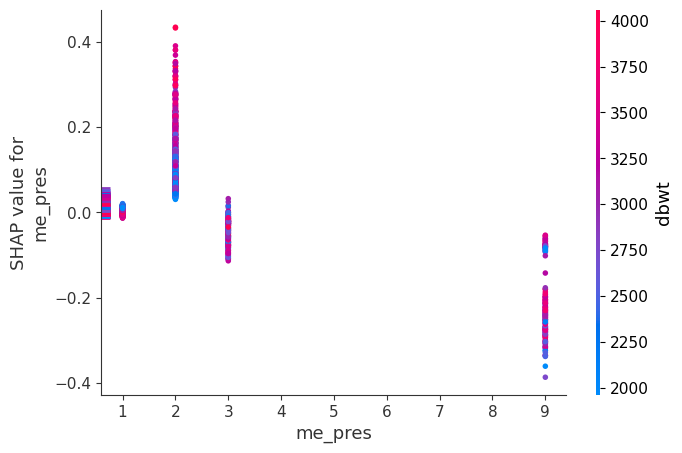


Feature: dmeth_rec


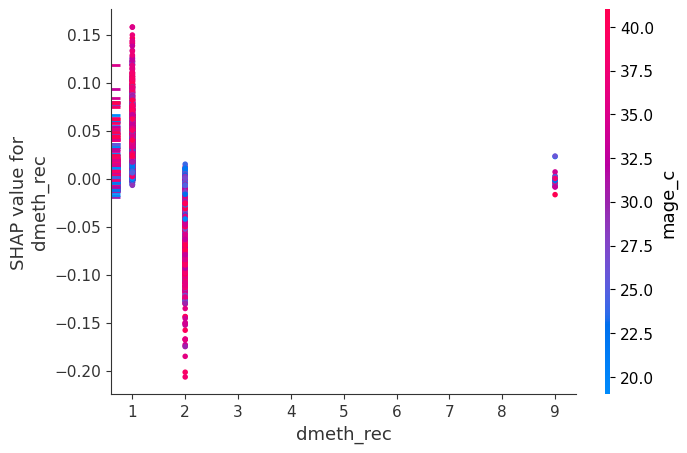


Feature: apgar5


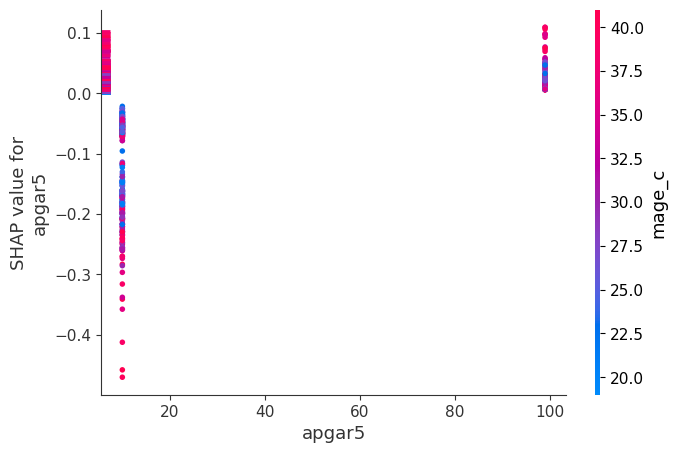


Feature: apgar10


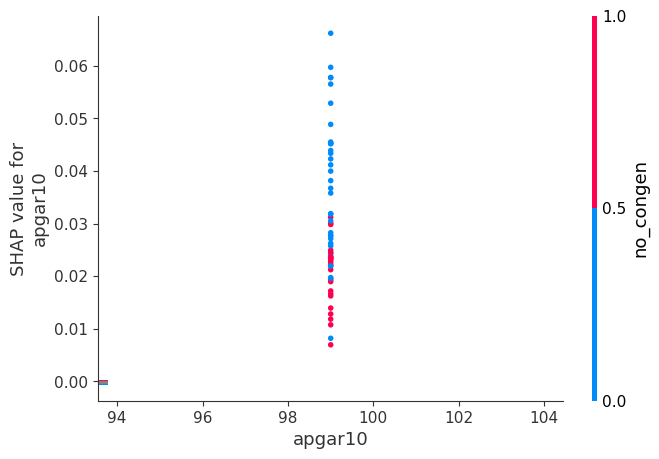


Feature: ab_aven1


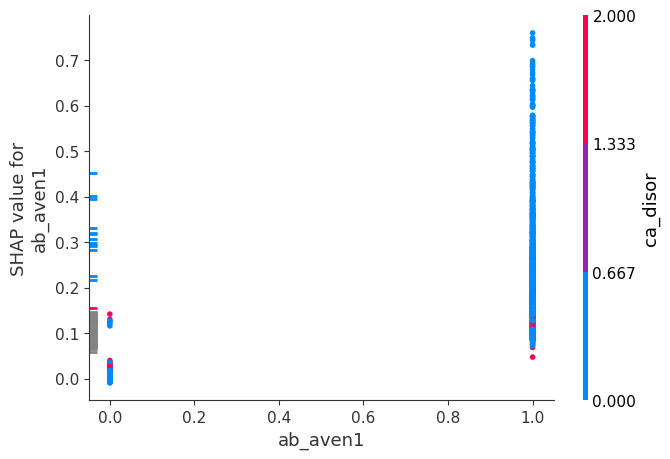


Feature: ab_aven6


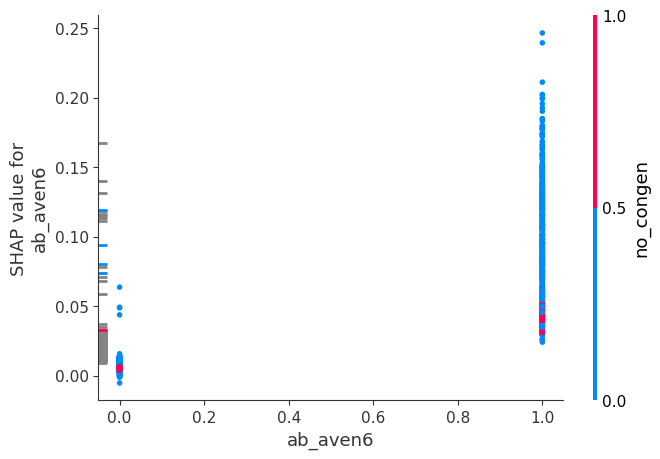


Feature: ab_nicu


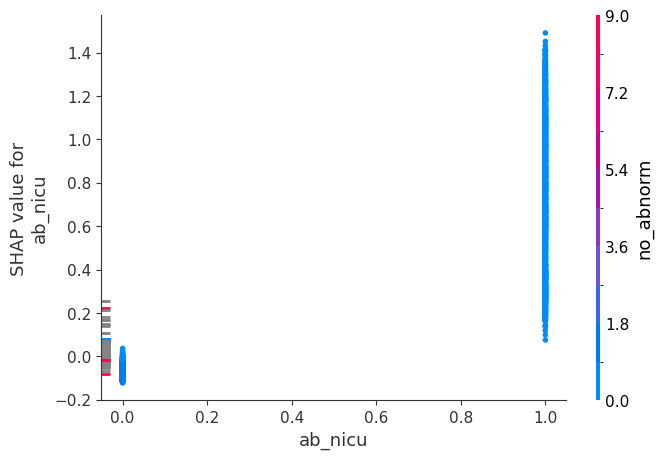


Feature: ab_surf


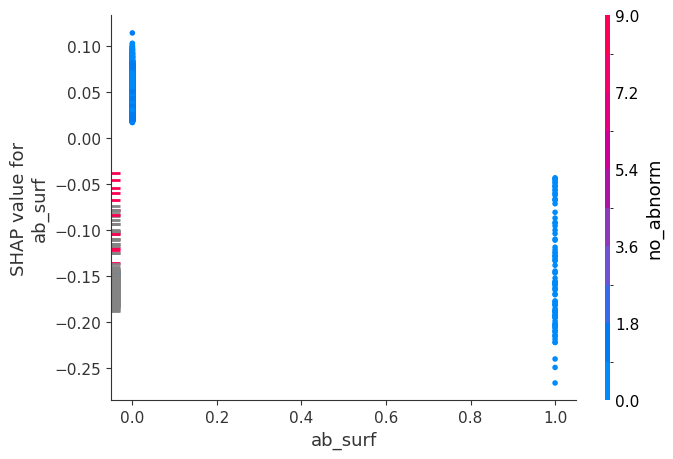


Feature: ab_anti


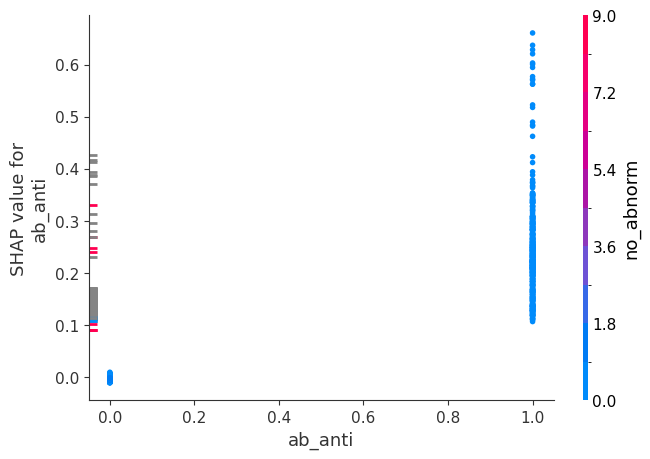


Feature: ab_seiz


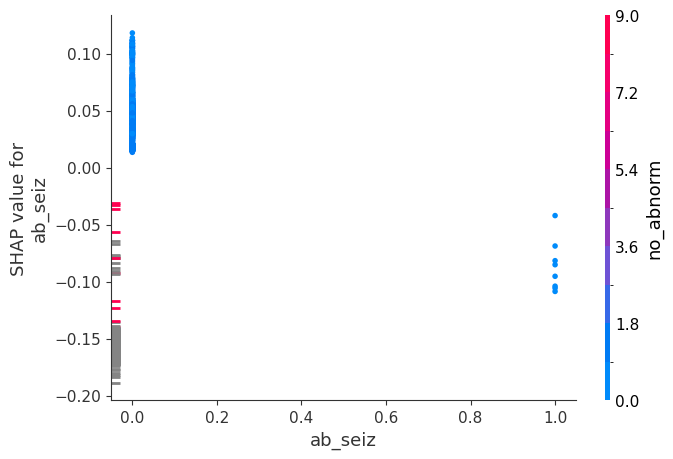


Feature: no_abnorm


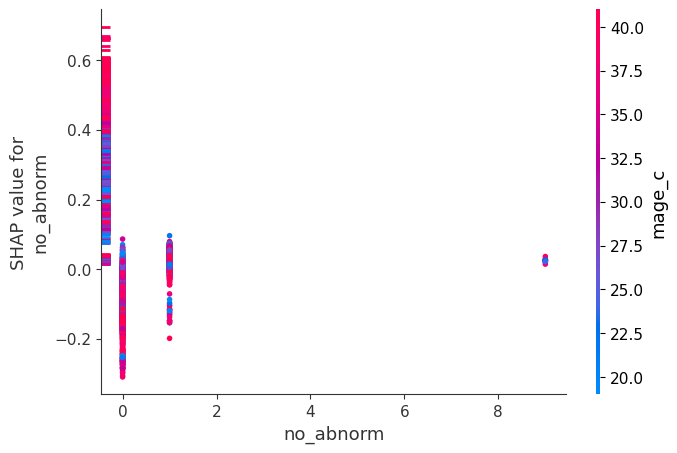


Feature: ca_anen


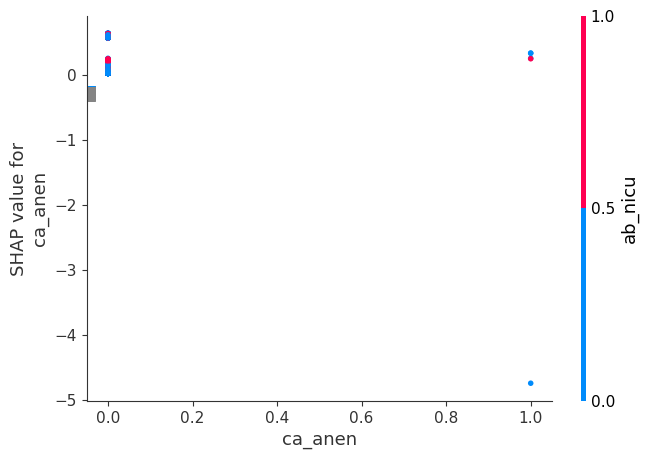


Feature: ca_mnsb


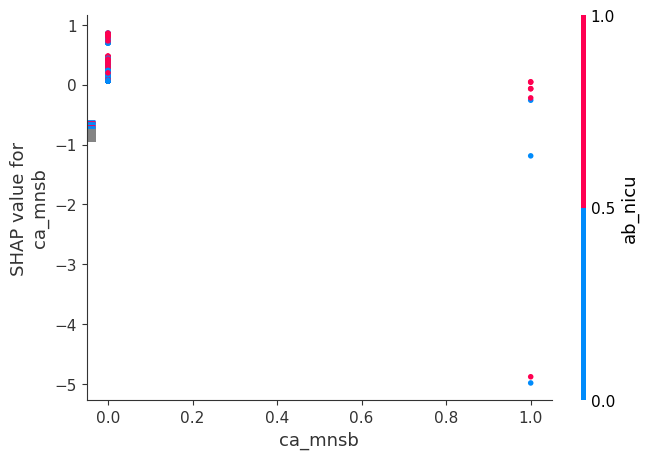


Feature: ca_cchd


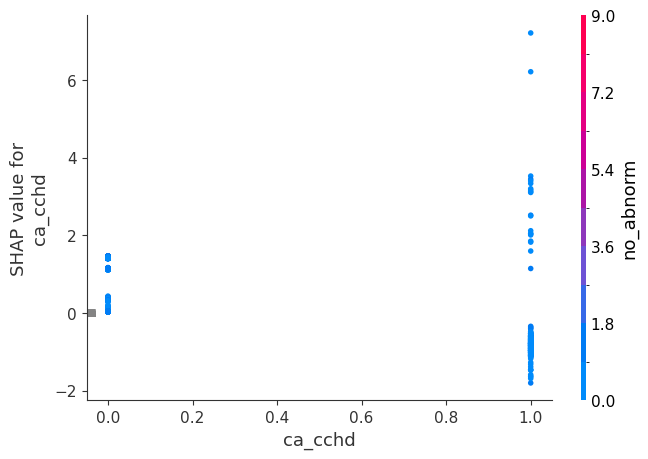


Feature: ca_cdh


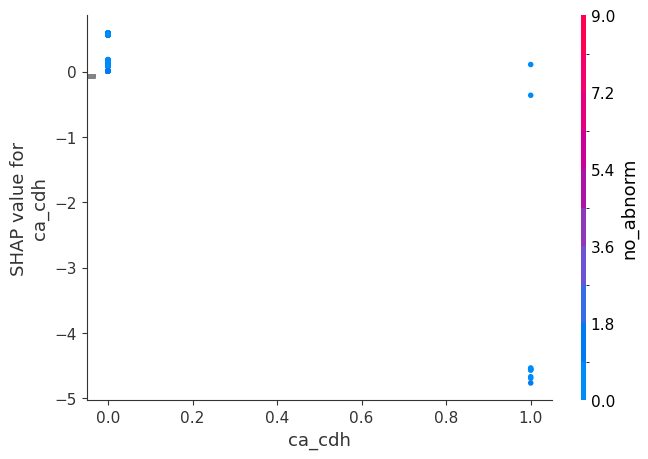


Feature: ca_omph


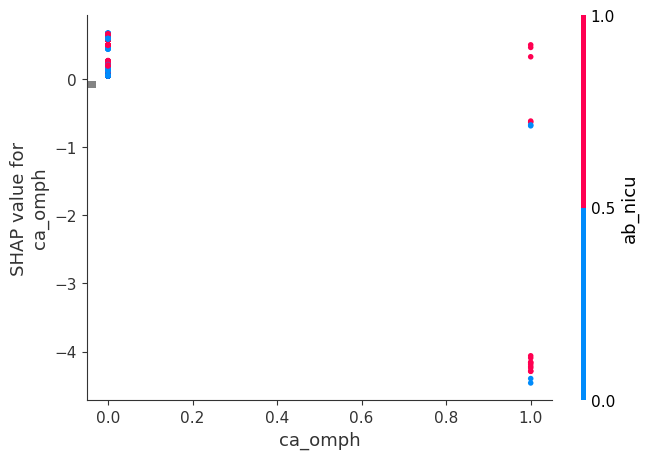


Feature: ca_gast


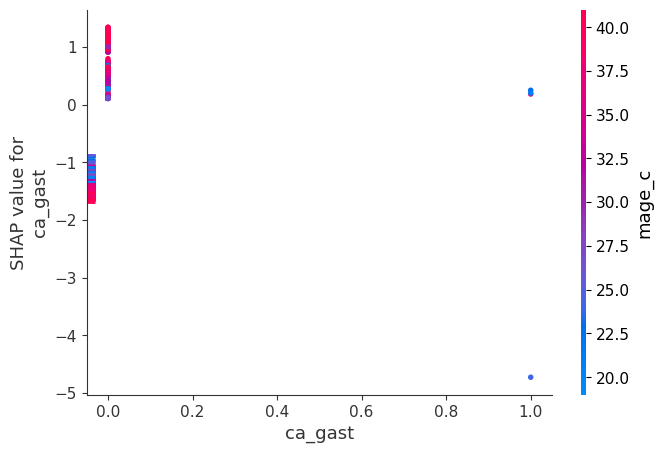


Feature: ca_limb


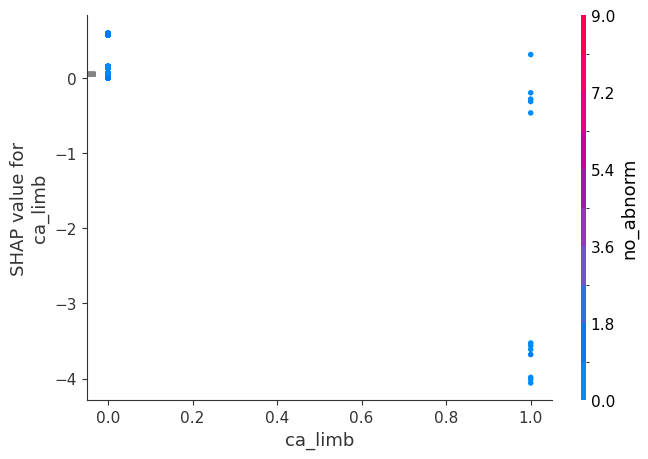


Feature: ca_cleft


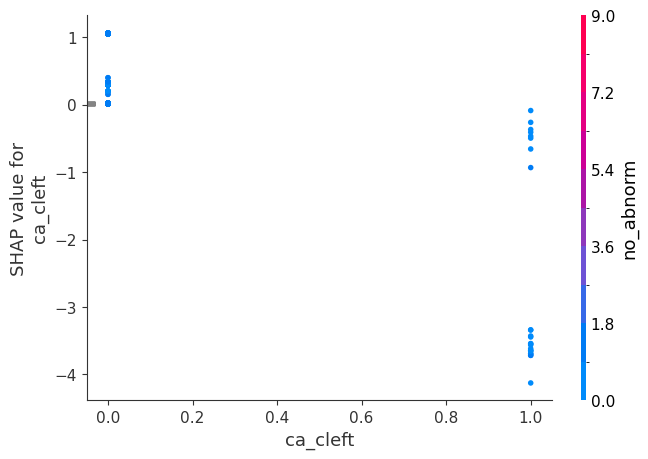


Feature: ca_clpal


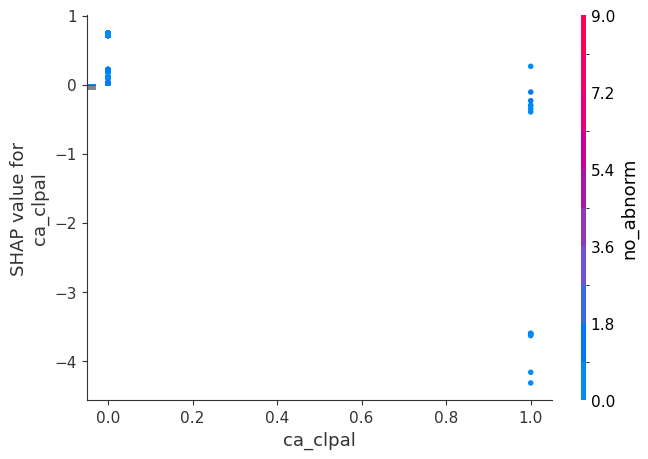


Feature: ca_hypo


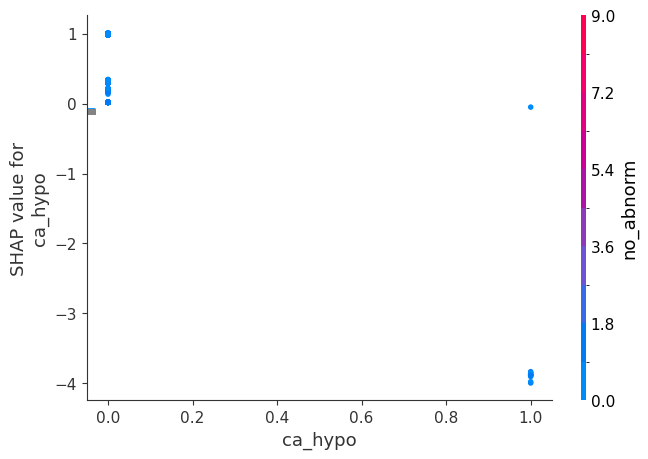


Feature: ca_disor


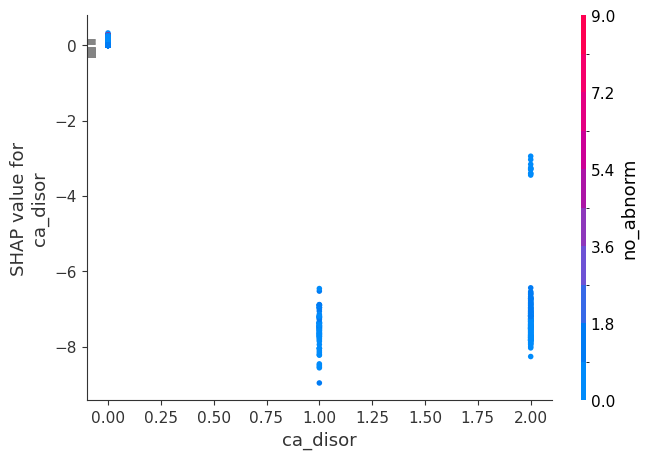


Feature: no_congen


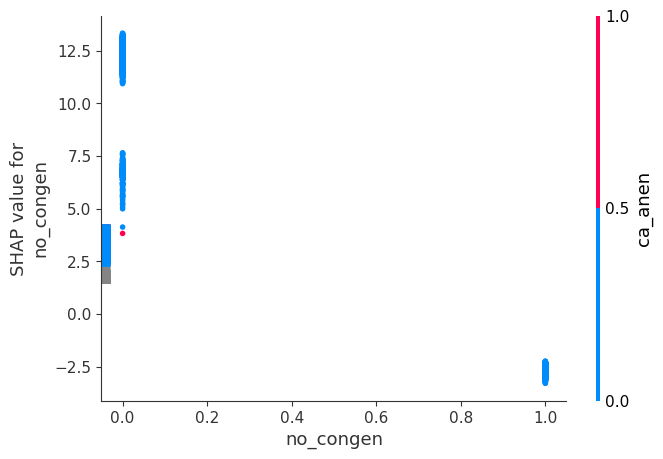


Feature: meduc


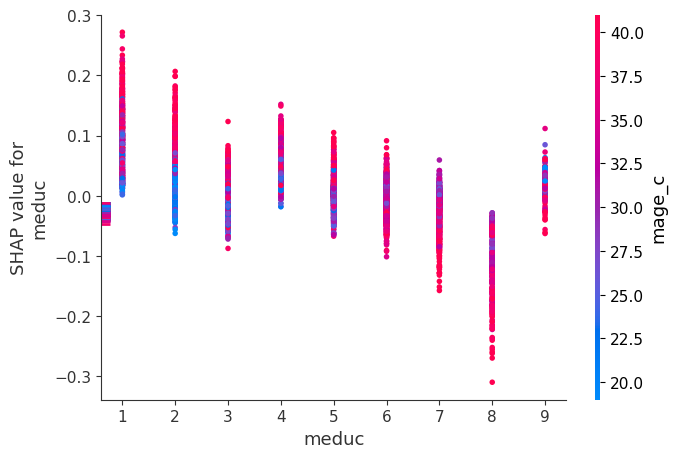


Feature: mracehisp


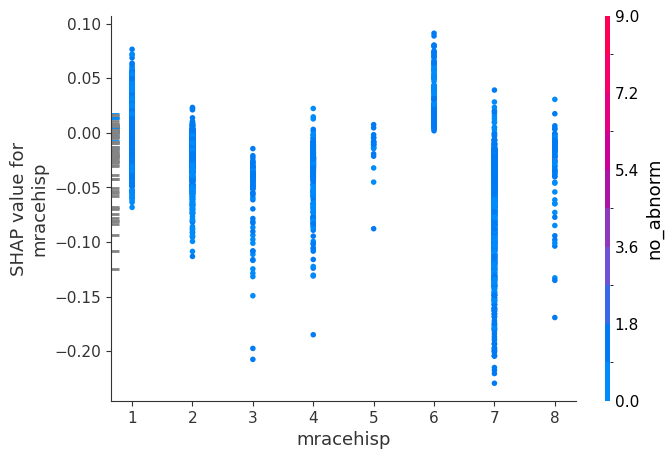


Feature: feduc


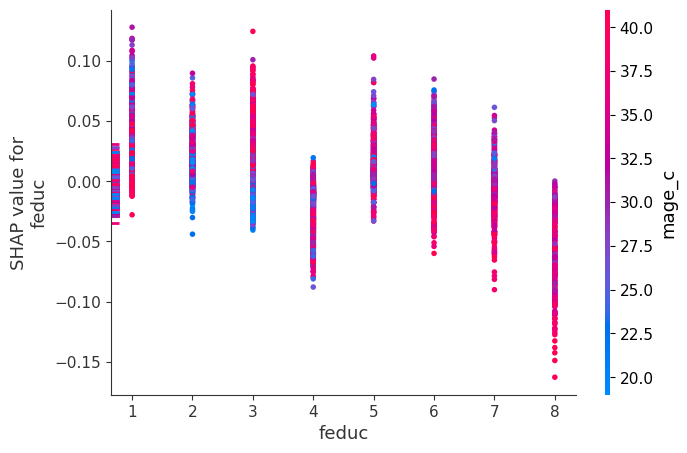


Feature: fracehisp


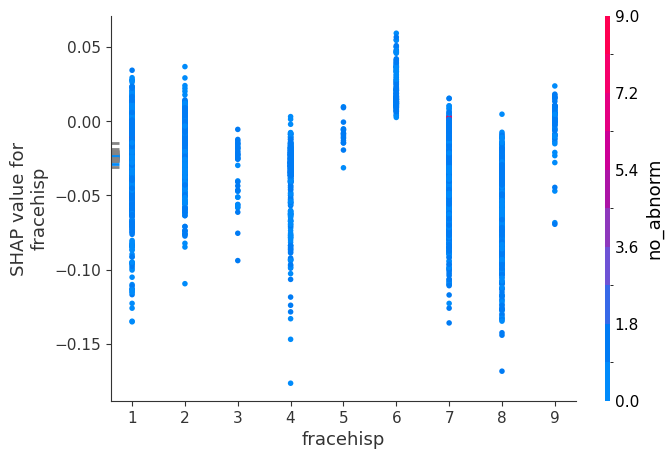


Feature: pay_rec


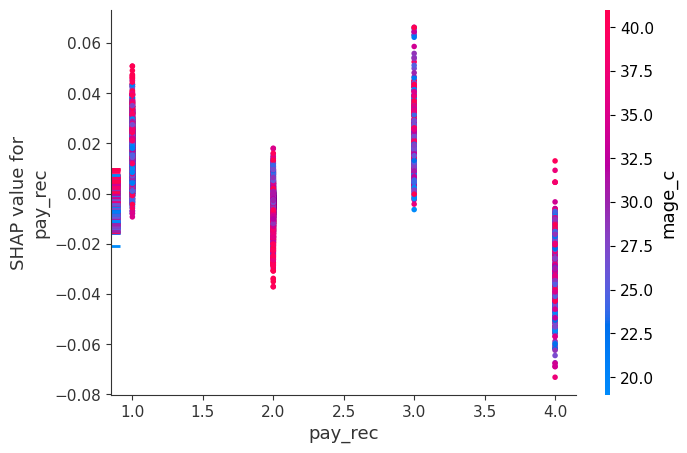


Feature: wic


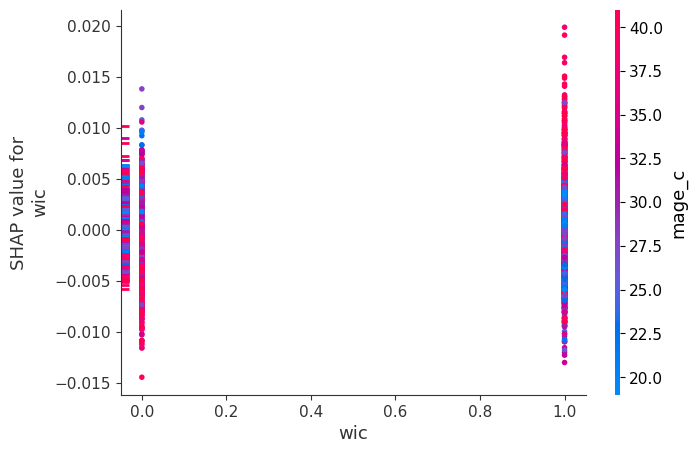


Feature: year


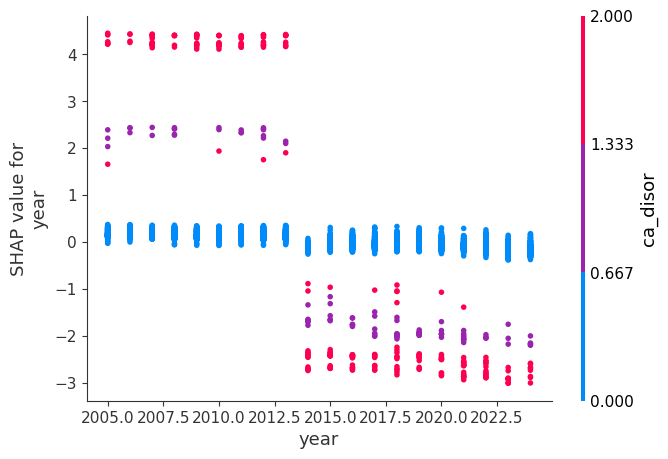


Feature: dbwt


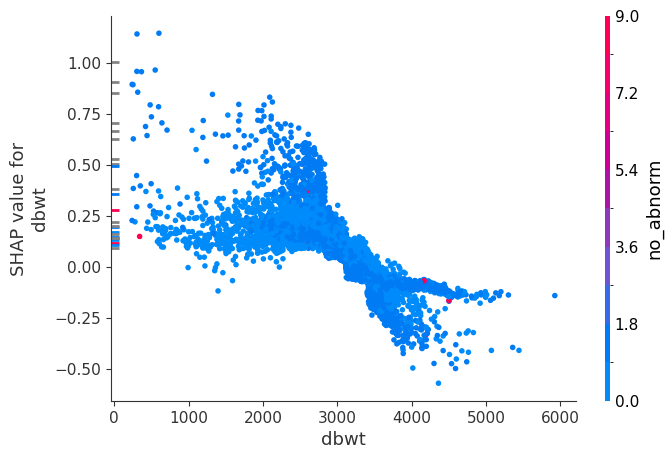


Feature: pwgt_r


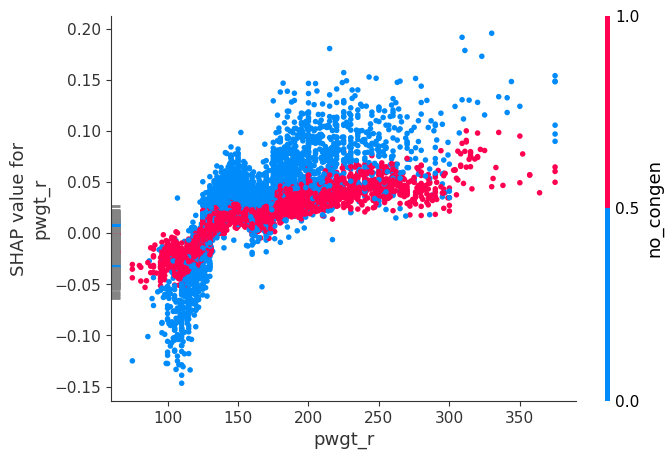


Feature: wtgain


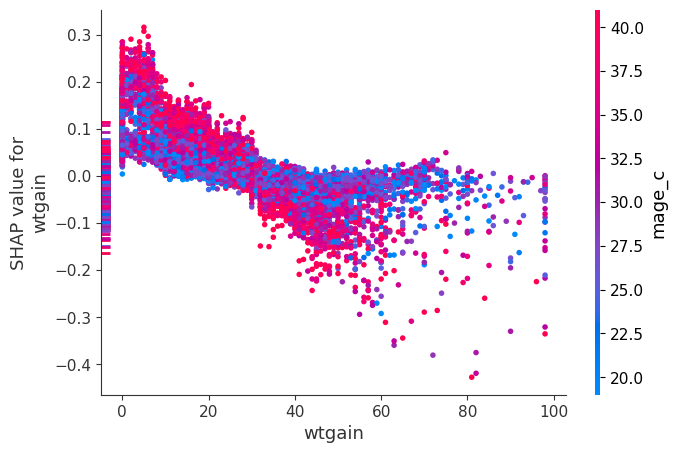


Feature: bmi


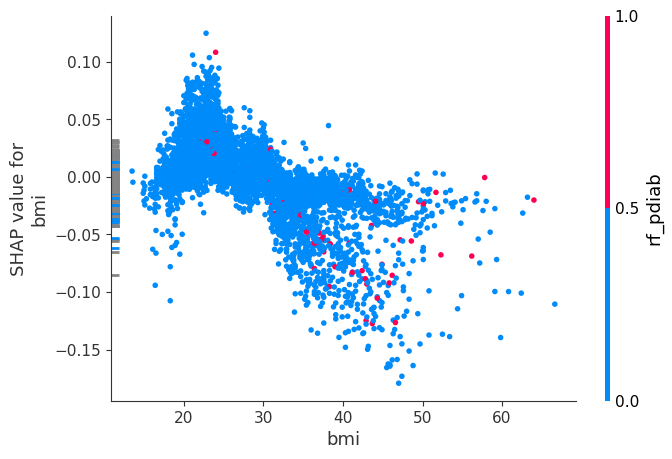


Feature: mage_c


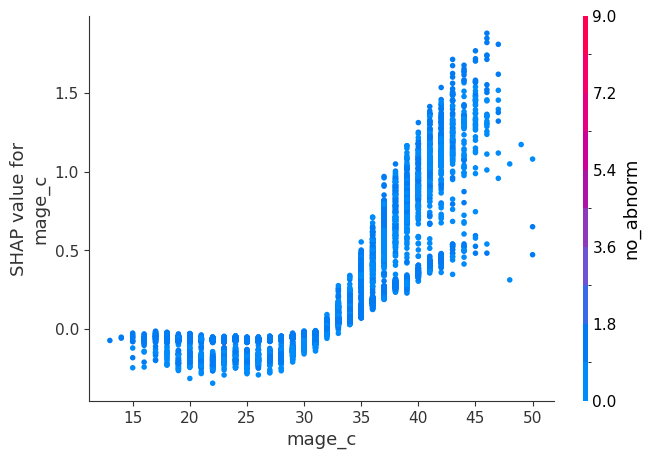


Feature: fagecomb


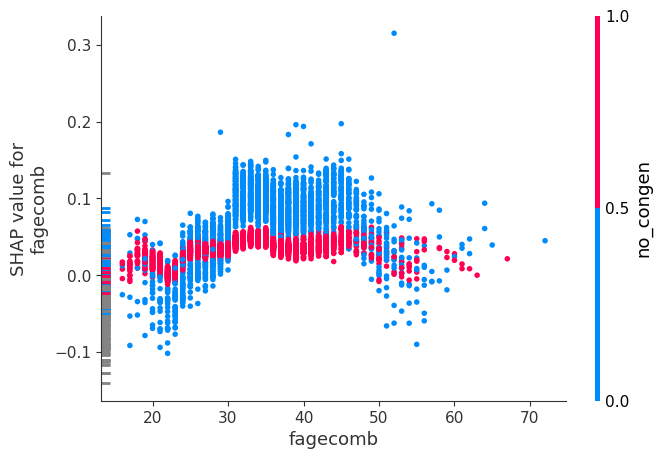

In [22]:
X_shap_fp = X_shap.astype("float32")
for name in X_shap_fp.columns:
    print(f"\nFeature: {name}")
    shap.dependence_plot(name, shap_values, X_shap_fp)

In [23]:
p_cal_raw = gbm.predict(X_cal, num_iteration=best_iter)  # (N_cal,)

calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

# calibrated probabilities on calibration set (for checking)
p_cal = calibrator.predict_proba(p_cal_raw.reshape(-1, 1))[:, 1]

NameError: name 'X_cal' is not defined

In [ ]:
from sklearn.metrics import brier_score_loss, log_loss

print("Uncalibrated logloss:", log_loss(y_cal, p_cal_raw, labels=[0,1]))
print("Calibrated   logloss:", log_loss(y_cal, p_cal,     labels=[0,1]))
print("Uncalibrated brier:  ", brier_score_loss(y_cal, p_cal_raw))
print("Calibrated   brier:  ", brier_score_loss(y_cal, p_cal))

In [ ]:
# Top-K precision (what fraction of the top K are truly positive?)
order = np.argsort(-p_valid)
y_sorted = y_valid.to_numpy()[order]

K = 10000
precision_at_k = y_sorted[:K].mean()
recall_at_k = y_sorted[:K].sum() / y_valid.sum()
precision_at_k, recall_at_k

In [ ]:
# Precision/recall at a chosen threshold

from sklearn.metrics import precision_recall_fscore_support

thr = 0.01
y_hat = (p_valid >= thr).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_valid, y_hat, average="binary")
prec, rec, f1


In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

# p_new = predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=best_iter)